# Read in the data

In [59]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [60]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [61]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [62]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [63]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [64]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [65]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [66]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [67]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [68]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
# survey_fields.remove("DBN")

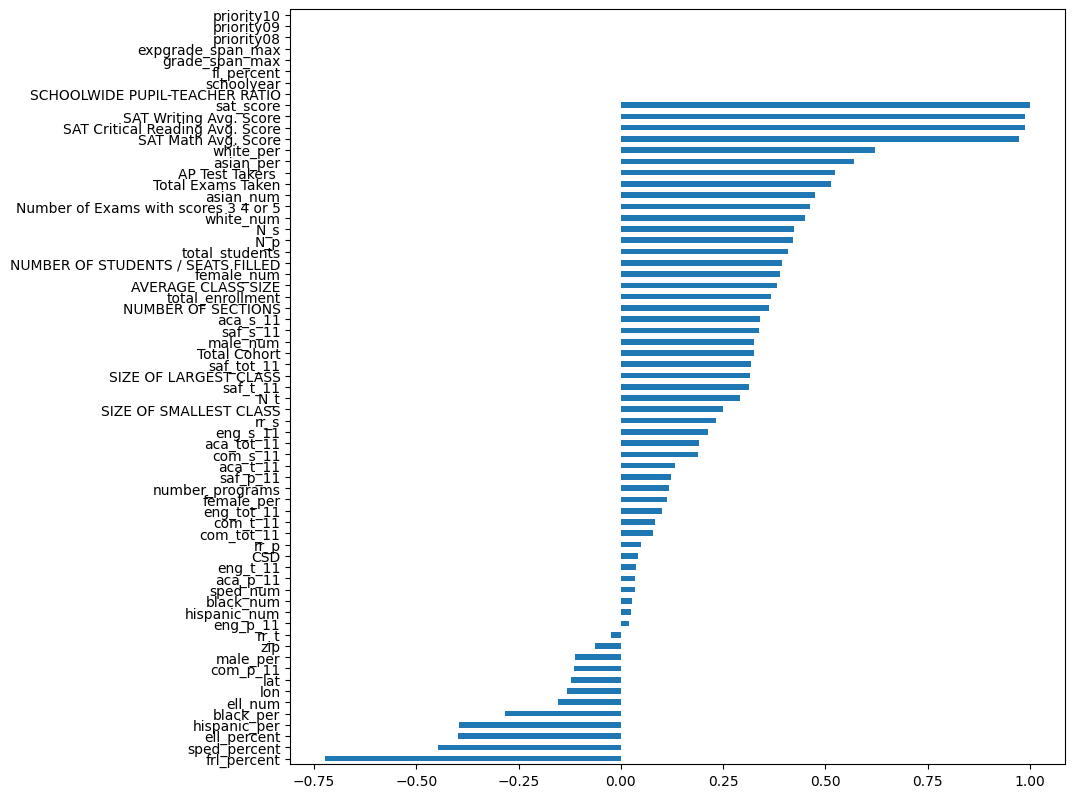

In [69]:
%matplotlib inline

correlations.sort_values(ascending=True).plot(kind='barh', figsize=(10,10))
plt.show()

# Investigating safety and SAT scores

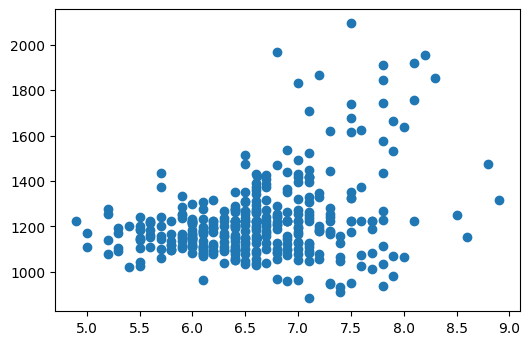

In [70]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.show()

There is a positive relationship, but it is not very large. There are a lot of clustered values for low saf_s_11 and low SAT scores.

In [71]:
print(combined.head())

      DBN                                        SCHOOL NAME  \
0  01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                         EAST SIDE COMMUNITY SCHOOL   
3  01M509                            MARTA VALLE HIGH SCHOOL   
4  01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                     44                            390.0   
4                    159                            522.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3   

In [72]:
print(combined.columns)

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)


In [73]:
print(combined[['boro','saf_s_11','sat_score']].head())
safety_per_borough = combined.loc[:,['boro','saf_s_11','sat_score']]

        boro  saf_s_11  sat_score
0  Manhattan  6.000000     1122.0
1  Manhattan  6.000000     1172.0
2  Manhattan  6.611667     1149.0
3  Manhattan  6.400000     1207.0
4  Manhattan  7.300000     1621.0


In [76]:
average_per_borough = safety_per_borough.groupby('boro').agg(np.mean)
print(average_per_borough)

               saf_s_11    sat_score
boro                                
Bronx          6.606577  1157.598203
Brooklyn       6.370755  1181.364461
Manhattan      6.831370  1278.331410
Queens         6.721875  1286.753032
Staten Island  6.530000  1382.500000


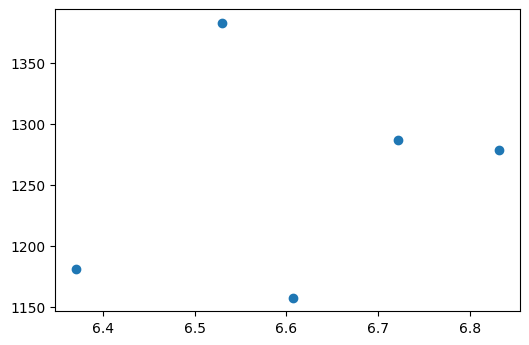

In [77]:
plt.scatter(average_per_borough['saf_s_11'], average_per_borough['sat_score'])

There seems to be a low correlation between safety and the SAT score per borough.

# Investigating race and SAT scores

In [87]:
race = combined[['white_per','asian_per','black_per','hispanic_per','sat_score']]
race_corr = race.corr()['sat_score']
print(race_corr)

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
sat_score       1.000000
Name: sat_score, dtype: float64


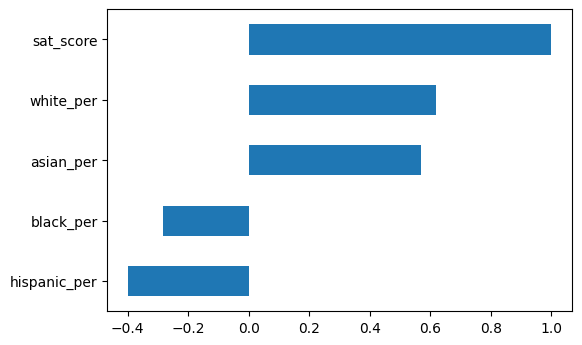

In [91]:
race_corr.sort_values(ascending=True).plot(kind='barh')
plt.show()

There is a positive correlation between being of white or asian race with SAT score. There is a negative correlation between being of black or hispanic race with SAT score.

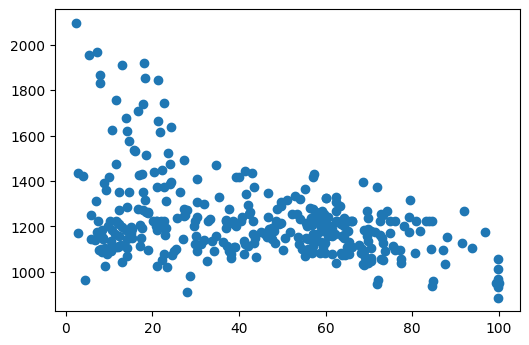

In [93]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.show()

There are many schools with low SAT score regardless of the % of hispanic race.

In [98]:
high_hispanic_low_sat = combined[(combined['hispanic_per'] > 95) & (combined['sat_score'] < 1200)]
print(high_hispanic_low_sat)

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
176  12X388   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
253  19K583                          MULTICULTURAL HIGH SCHOOL   
286  24Q296             PAN AMERICAN INTERNATIONAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   
176                     30 

# Investigating gender

In [99]:
gender = combined[['male_per','female_per','sat_score']]
gender_corr = gender.corr()['sat_score']
print(gender_corr)

male_per     -0.112062
female_per    0.112108
sat_score     1.000000
Name: sat_score, dtype: float64


Males seem to do worse on the SAT compared to females.

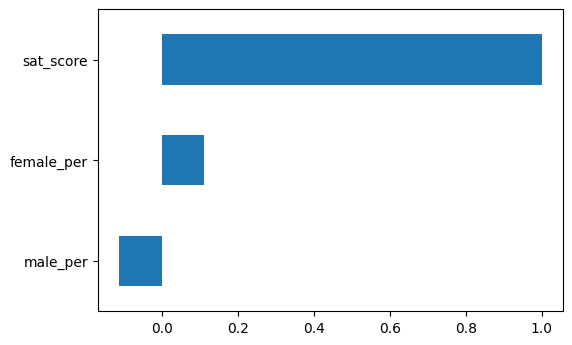

In [100]:
gender_corr.sort_values(ascending=True).plot(kind='barh')
plt.show()

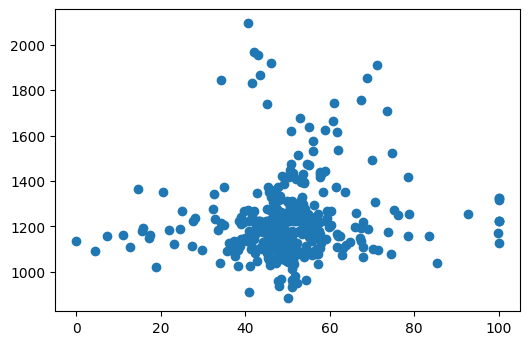

In [101]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.show()

In [102]:
high_female_high_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] < 1700)]
print(high_female_high_sat)

        DBN                                        SCHOOL NAME  \
9    02M296              HIGH SCHOOL OF HOSPITALITY MANAGEMENT   
14   02M308                       LOWER MANHATTAN ARTS ACADEMY   
15   02M316  URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...   
16   02M374                          GRAMERCY ARTS HIGH SCHOOL   
22   02M408           PROFESSIONAL PERFORMING ARTS HIGH SCHOOL   
27   02M418                             MILLENNIUM HIGH SCHOOL   
29   02M420  HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...   
34   02M439                          MANHATTAN VILLAGE ACADEMY   
40   02M519                       TALENT UNLIMITED HIGH SCHOOL   
43   02M531     REPERTORY COMPANY HIGH SCHOOL FOR THEATRE ARTS   
45   02M543                             NEW DESIGN HIGH SCHOOL   
48   02M580           RICHARD R. GREEN HIGH SCHOOL OF TEACHING   
49   02M600              THE HIGH SCHOOL OF FASHION INDUSTRIES   
58   03M415  WADLEIGH SECONDARY SCHOOL FOR THE PERFORMING &...   
69   04M55

In [104]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

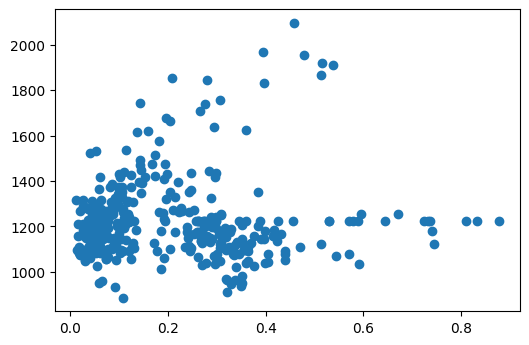

In [106]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.show()

There is a low positive correlation between these two variables, but it is only a small one.